Loaded DNp25_ChR_female_sp2_save_2024-06-06-161827-0000.tif with shape (999, 1024, 1280)


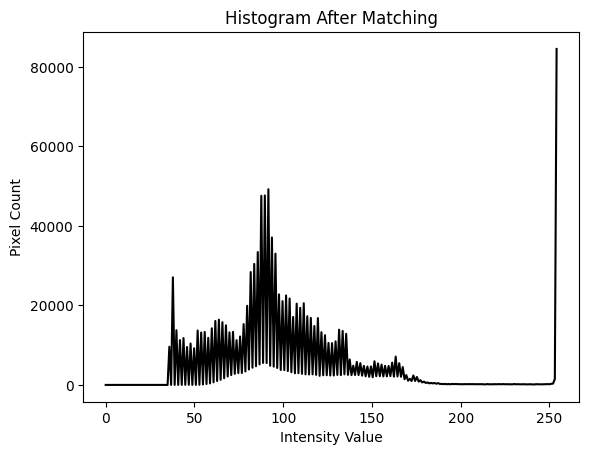

Saved processed stack to /Users/camellyc/Library/Mobile Documents/com~apple~CloudDocs/学习/Lab/Tuthill Lab/Spiracle/spiracle images and movies/processed/processed_stack_0.tif


In [5]:
import imageio
import numpy as np
from skimage.registration import phase_cross_correlation
from skimage import exposure
from scipy.ndimage import shift
import tifffile as tiff
import os
import matplotlib.pyplot as plt

def load_images(directory):
    images = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith('.tif'):
            try:
                img = imageio.volread(os.path.join(directory, filename))
                print(f"Loaded {filename} with shape {img.shape}")
                images.append(img)
            except Exception as e:
                print(f"Failed to load {filename}: {e}")
    return images

def plot_histogram(image, title):
    plt.figure()
    if image.ndim == 3:
        image = image[0]  # Histogram of first slice
    histogram, bin_edges = np.histogram(image, bins=256, range=(0, 255))
    plt.plot(bin_edges[:-1], histogram, color='black')
    plt.title(title)
    plt.xlabel('Intensity Value')
    plt.ylabel('Pixel Count')
    plt.show()

def match_intensity(images):
    reference_image = images[0][0]  # First image in the first stack
    adjusted_images = []
    for stack in images:
        adjusted_stack = [exposure.match_histograms(img, reference_image) for img in stack]
        adjusted_images.append(np.stack(adjusted_stack))
        plot_histogram(adjusted_stack[0], "Histogram After Matching")
    return adjusted_images

def register_images(images):
    # Adjust the intensity of all images to the first image
    matched_images = match_intensity(images)
    
    reference_image = matched_images[0][0]  # First image of the first stack as the reference
    registered_images = []
    for stack in matched_images:
        registered_stack = []
        for img in stack:
            shift_estimation, _, _ = phase_cross_correlation(reference_image, img)
            registered_slice = shift(img, shift_estimation, mode='nearest')
            registered_stack.append(registered_slice)
        registered_images.append(np.stack(registered_stack))
    return registered_images

def save_images(images, directory):
    for idx, stack in enumerate(images):
        output_path = os.path.join(directory, f'processed_stack_{idx}.tif')
        tiff.imwrite(output_path, stack)
        print(f"Saved processed stack to {output_path}")

def process_images(directory):
    images = load_images(directory)
    registered_images = register_images(images)
    return registered_images

# Example usage:
directory = '/Users/camellyc/Library/Mobile Documents/com~apple~CloudDocs/学习/Lab/Tuthill Lab/Spiracle/spiracle images and movies/to_process'
processed_images = process_images(directory)
save_images(processed_images, '/Users/camellyc/Library/Mobile Documents/com~apple~CloudDocs/学习/Lab/Tuthill Lab/Spiracle/spiracle images and movies/processed')
